In [1]:
import numpy as np
import torchvision as tv
import matplotlib.pyplot as plt
import torch
import os
import torch.nn as nn
import BasicFunctions as bf

from skimage.measure import compare_psnr
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.nn import functional as F 

In [2]:
os.chdir('C:\\Users\\Yaroslav\\YandexDisk\\Pr\\Py\\ML\\DataCreation\\output')
X = np.load('X_base_ones9.npz')
y = np.load('Y_base3.npz')
name = 'city'

ym = np.mean(y[name])#, axis = (1,2)).reshape(y[name].shape[0], 1, 1)
ys = np.std(y[name])#, axis = (1,2)).reshape(y[name].shape[0], 1, 1)
Xm = np.mean(X[name])#, axis = (1,2)).reshape(y[name].shape[0], 1, 1)
Xs = np.std(X[name])#, axis = (1,2)).reshape(y[name].shape[0], 1, 1)
X_norm = (X[name] - Xm) / Xs
y_norm = (y[name] - ym) / ys

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm)
batch_size = 2000

train_loader = DataLoader(
    dataset=list(zip(X_train, y_train)), 
    batch_size=batch_size, 
    shuffle=True)

test_loader = DataLoader(
    dataset=list(zip(X_test, y_test)), 
    batch_size=batch_size, 
    shuffle=True)

In [26]:
class IndСircleConv2(nn.Module):
    def __init__(self):
        super(IndСircleConv2, self).__init__()
        
        self.A00 = nn.Conv2d(1, 1, (3,3))
        self.A01 = nn.Conv2d(1, 1, (3,3))
        self.A02 = nn.Conv2d(1, 1, (3,3))
        self.A10 = nn.Conv2d(1, 1, (3,3))
        self.A11 = nn.Conv2d(1, 1, (3,3))
        self.A12 = nn.Conv2d(1, 1, (3,3))
        self.A20 = nn.Conv2d(1, 1, (3,3))
        self.A21 = nn.Conv2d(1, 1, (3,3))
        self.A22 = nn.Conv2d(1, 1, (3,3))
    
    def forward(self, x):
        out = F.interpolate(x.reshape(x.shape[0], 1, 3, 3), scale_factor=3,
                              mode='bilinear', align_corners=True)
    
        out[:, :, 3, 3] = self.A00(out[:, :, 2:5, 2:5])[:, :, 0, 0]
        out[:, :, 3, 5] = self.A02(out[:, :, 2:5, 4:7])[:, :, 0, 0]
        out[:, :, 5, 5] = self.A22(out[:, :, 4:7, 4:7])[:, :, 0, 0]
        out[:, :, 5, 3] = self.A20(out[:, :, 4:7, 2:5])[:, :, 0, 0]
        out[:, :, 4, 3] = self.A10(out[:, :, 3:6, 2:5])[:, :, 0, 0]
        out[:, :, 3, 4] = self.A01(out[:, :, 2:5, 3:6])[:, :, 0, 0]
        out[:, :, 4, 5] = self.A12(out[:, :, 3:6, 4:7])[:, :, 0, 0]
        out[:, :, 5, 4] = self.A21(out[:, :, 4:7, 3:6])[:, :, 0, 0]
        out[:, :, 4, 4] = self.A11(out[:, :, 3:6, 3:6])[:, :, 0, 0]

        return out[:, :, 3:6, 3:6]

In [9]:
class IndConv2(nn.Module):
    def __init__(self):
        super(IndConv2, self).__init__()
        
        self.A00 = nn.Conv2d(1, 1, (3,3))
        self.A01 = nn.Conv2d(1, 1, (3,3))
        self.A02 = nn.Conv2d(1, 1, (3,3))
        self.A10 = nn.Conv2d(1, 1, (3,3))
        self.A11 = nn.Conv2d(1, 1, (3,3))
        self.A12 = nn.Conv2d(1, 1, (3,3))
        self.A20 = nn.Conv2d(1, 1, (3,3))
        self.A21 = nn.Conv2d(1, 1, (3,3))
        self.A22 = nn.Conv2d(1, 1, (3,3))
    
    def forward(self, x):
        ins = F.interpolate(x.reshape(x.shape[0], 1, 3, 3), scale_factor=3)#,
                              #mode='bilinear', align_corners=True)
        out = torch.ones((x.shape[0], 1, 3, 3)).type(torch.cuda.FloatTensor)
    
        out[:, :, 0, 0] = self.A00(ins[:, :, 2:5, 2:5])[:, :, 0, 0]
        out[:, :, 0, 2] = self.A02(ins[:, :, 2:5, 4:7])[:, :, 0, 0]
        out[:, :, 2, 2] = self.A22(ins[:, :, 4:7, 4:7])[:, :, 0, 0]
        out[:, :, 2, 0] = self.A20(ins[:, :, 4:7, 2:5])[:, :, 0, 0]
        out[:, :, 1, 0] = self.A10(ins[:, :, 3:6, 2:5])[:, :, 0, 0]
        out[:, :, 0, 1] = self.A01(ins[:, :, 2:5, 3:6])[:, :, 0, 0]
        out[:, :, 1, 2] = self.A12(ins[:, :, 3:6, 4:7])[:, :, 0, 0]
        out[:, :, 2, 1] = self.A21(ins[:, :, 4:7, 3:6])[:, :, 0, 0]
        out[:, :, 1, 1] = self.A11(ins[:, :, 3:6, 3:6])[:, :, 0, 0]

        return out

In [48]:
 class convNet(nn.Module):
    def __init__(self):
        super(convNet, self).__init__()
        self.indC1 = IndСircleConv2()
        self.indC2 = IndСircleConv2()
        self.indC3 = IndСircleConv2()
        
    def forward(self, x):
        out = F.relu(self.indC1(x))
        out = F.relu(self.indC2(out))
        out = self.indC2(out)
        return out

In [10]:
 class convNet(nn.Module):
    def __init__(self):
        super(convNet, self).__init__()
        self.indC1 = IndConv2()
        self.indC2 = IndConv2()
        self.indC3 = IndConv2()
        
    def forward(self, x):
        out = self.indC1(x)
        out = self.indC2(out)
        out = self.indC2(out)
        return out

In [49]:
cuda_net = convNet()
cuda_net = cuda_net.cuda()

In [50]:
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cuda_net.parameters(), lr=learning_rate)

In [51]:
train_cuda_MSE, test_cuda_MSE = bf.net_cuda_training(cuda_net, train_loader, test_loader,
                                                     criterion, learning_rate, 20)

tensor(1.1733, device='cuda:0')


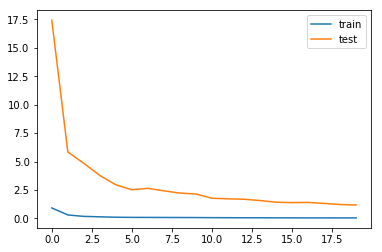

In [31]:
print(test_cuda_MSE[-1])
plt.plot(train_cuda_MSE, label='train')
plt.plot(test_cuda_MSE, label= 'test')
plt.legend()
plt.show()

tensor(2.8748, device='cuda:0')


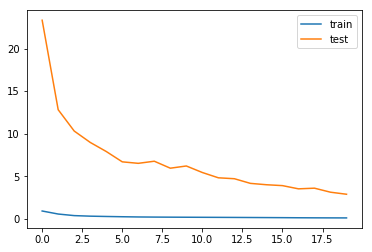

In [52]:
print(test_cuda_MSE[-1])
plt.plot(train_cuda_MSE, label='train')
plt.plot(test_cuda_MSE, label= 'test')
plt.legend()
plt.show()

tensor(5.0611, device='cuda:0')


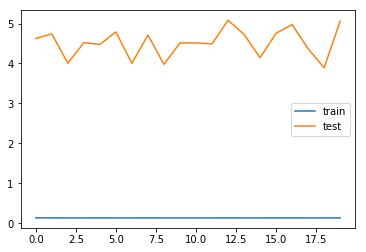

In [21]:
print(test_cuda_MSE[-1])
plt.plot(train_cuda_MSE, label='train')
plt.plot(test_cuda_MSE, label= 'test')
plt.legend()
plt.show()

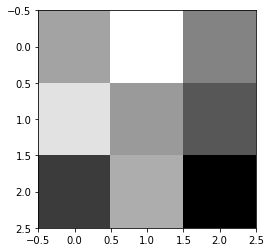

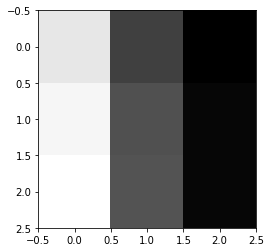

In [53]:
plt.imshow(cuda_net(torch.tensor(X_test[0]).reshape(1, 1, 3, 3).type(torch.cuda.FloatTensor)).data.reshape(3, 3), cmap='gray')
plt.show()
plt.imshow(y_test[0], cmap='gray')

In [54]:
rest_picture = cuda_net(torch.cuda.FloatTensor(X_norm)).squeeze(1).type(torch.FloatTensor).detach().numpy()

In [58]:
rest_picture.shape

(268324, 3, 3)

In [55]:
compare_psnr(bf.whole_pic(y_norm)[:90, :90], bf.whole_pic(rest_picture)[:90, :90], data_range=np.max(y_norm) - np.min(y_norm))

30.671530380058982

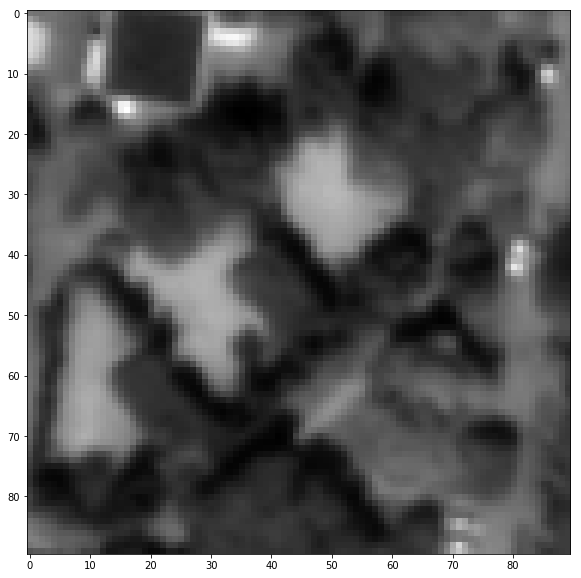

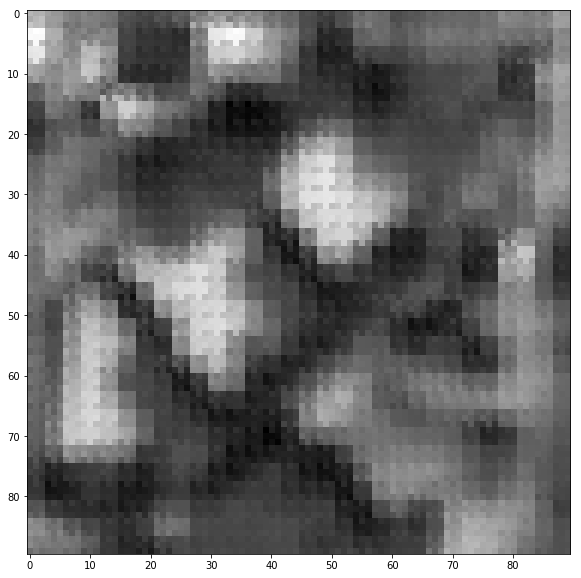

In [56]:
plt.figure(figsize=(10,10))
plt.imshow(bf.whole_pic(y_norm)[:90, :90], cmap='gray')
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(bf.whole_pic(rest_picture)[:90, :90], cmap='gray')
#plt.figure(figsize=(10,10))
#plt.imshow(bf.whole_pic(X[name])[:30, :30], cmap='gray')

In [36]:
def whole_pic_overlap(X):
    """Make one picture from array X of pictures with overlap
    """
    L = int(X.shape[0] ** 0.5 * (X.shape[1] - 2))
    picture = np.zeros((L, L))
    d = int((X.shape[1]) - 2)
    k = 0
    for i in range(0, L, d):
        for j in range(0, L, d):
            picture[i: i + d, j: j + d] = X[k, 1, 1]
            k += 1
    return picture

In [37]:
bad_pic = whole_pic_overlap(X_norm)

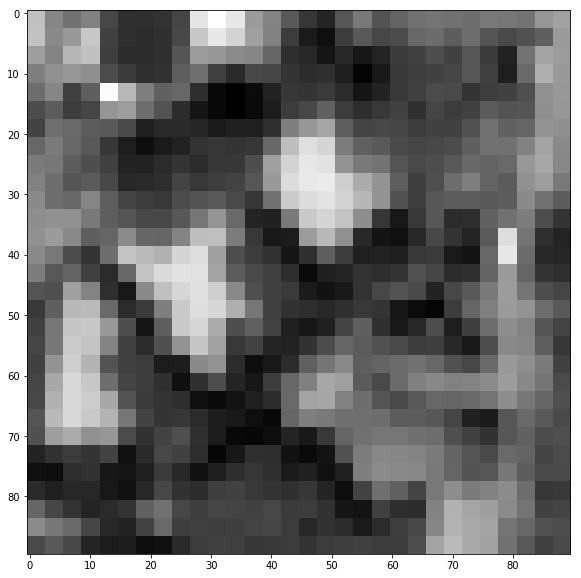

In [47]:
plt.figure(figsize=(10,10))
plt.imshow(F.interpolate(torch.FloatTensor(bad_pic.reshape(1, 1, bad_pic.shape[0], bad_pic.shape[0])), scale_factor=3).squeeze(0).squeeze(0)[:90,:90], cmap='gray')

In [133]:
from sklearn.cluster import DBSCAN

In [134]:
model = DBSCAN()

In [ ]:
labels = model.fit_predict(y_norm.reshape(y_norm.shape[0], 9))

In [130]:
model.predict(np.ones((1,9)))

array([8])

[8]


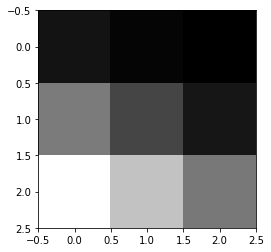

[6]


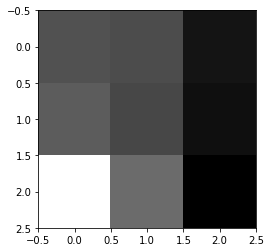

[6]


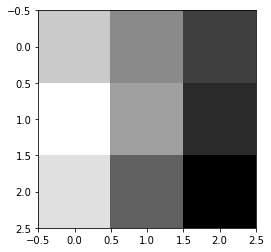

[4]


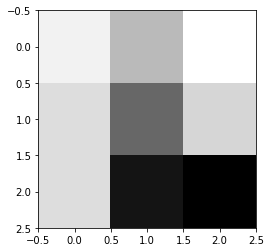

[6]


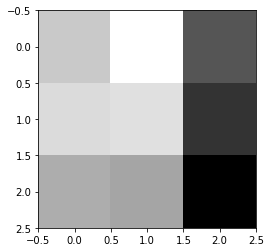

[7]


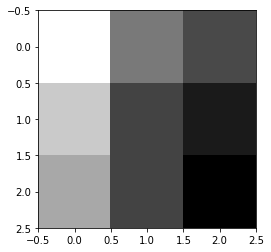

[7]


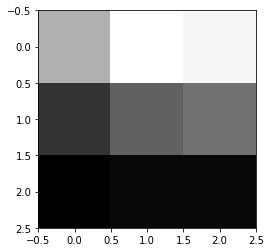

[7]


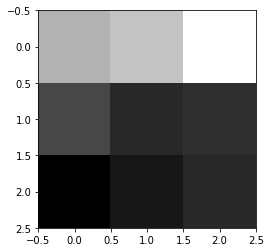

[7]


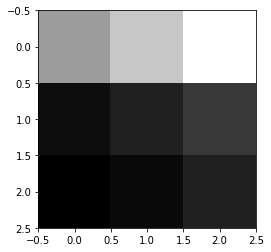

[4]


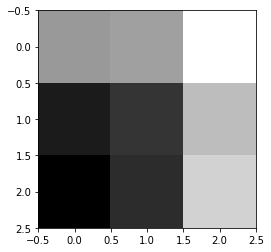

[8]


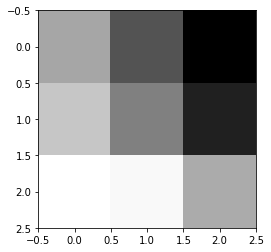

[4]


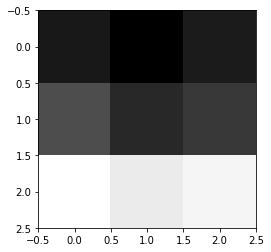

[6]


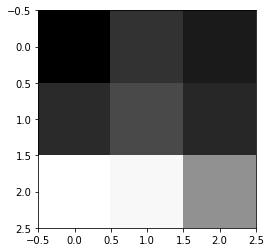

[4]


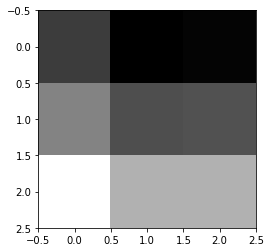

[4]


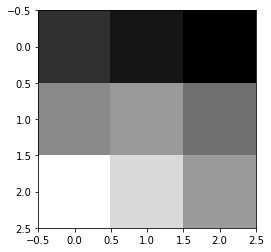

[0]


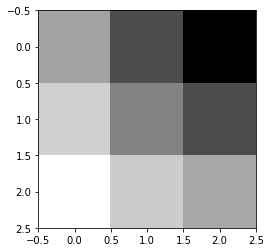

[7]


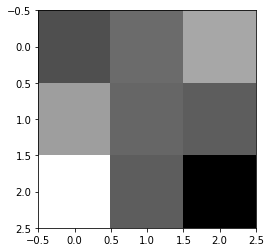

[0]


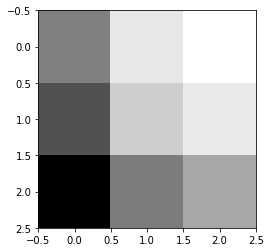

[4]


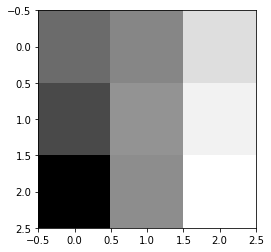

[4]


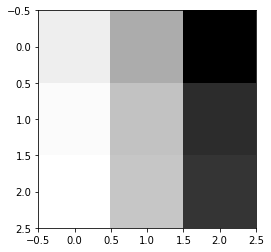

In [132]:
for i in range(20):
    print(model.predict(y_norm[i].reshape(1, 9)))
    plt.imshow(y_norm[i], cmap='gray')
    plt.show()